In [2]:
using Plots

# Chapter 6: Temporal-Difference Learning

Temporal Difference learning utilizes _bootstrapping_ to more effectively learn from experience. It can be seen as a mixture of dynamic programming's ability to learn from existing estimates and Monte Carlo's ability to learn from experience (as opposed to using a model). We can generalize both DP and Monte Carlo into TD($\lambda$) (Chapter 12).

TD approaches function as alternate ways of solving the prediction problem. For policy improvement, they typically use a policy improvement step that optimizes the policy with respect to the learned value function. The different TD methods all principally differ in how they approach using temporal differences in solving the prediction problem.

## 6.1 TD Prediction


Consider a **non-stationary Monte Carlo** prediction scheme

$$
V(S_t) \gets V(S_t) + \alpha \left[G_t - V(S_t)\right]
$$

Note that the step size is constant here, indicating that this represents an exponentially weighted average over the past observations. This is what allows the update to deal with non-stationary processes.

Compare it with the **temporal difference prediction** update scheme:

$$
\begin{align*}
V(S_t) &\gets V(S_t) + \alpha\left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)\right]\\\\
\end{align*}
$$

Where the update is based on the _TD-error_

$$
\begin{align*}
\delta_t &\;\dot{=}\; R_{t+1} + \gamma V(S_{t+1}) - V(S_t)
\end{align*}
$$

We can demonstrate a relationship between the TD-error and the Monte Carlo error ($G_t - V(S_t)$)

$$
\begin{align*}
G_t - V(S_t) &= R_{t+1} + \gamma G_{t+1} - V(S_t)\\\\
&= R_{t+1} + \gamma G_{t+1} - V(S_t) + \gamma V(S_{t+1}) - \gamma V(S_{t+1})\\\\
&= R_{t+1} + \gamma V(S_{t+1}) - V(S_t) + \gamma G_{t+1} - \gamma V(S_{t+1})\\\\
&= \delta_t + \gamma\left(G_{t+1} - V(S_{t+1})\right)\\\\
&= \delta_t + \gamma(\delta_{t+1} + \gamma(G_{t+2} - V(S_{t+2}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2(G_{t+2} - V(S_{t+2}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2(\delta_{t+2} + \gamma(G_{t+3} - V(S_{t+3}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2\delta_{t+2} + \cdots + \gamma^{T-t-1}\delta_{T-1} + \gamma^{T-1}(G_{T} - V(S_{T}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2\delta_{t+2} + \cdots + \gamma^{T-t-1}\delta_{T-1} + \gamma^{T-1}(0 - 0)\\\\
&= \sum_{k=t}{\gamma^{k-t}\delta_k}
\end{align*}
$$

TD prediction makes use both of sampling _and_ bootstrapping.

1. DP makes use of the model and bootstrapping.
2. Monte Carlo makes use of sampling returns
3. TD prediction makes use of sampled returns as well as bootstrapping, without a model.

> _Exercise 6.1_ If $V$ changes during the episode, then (6.6) only holds approximately; what would the difference be between the two sides? Let $V_t$ denote the array of state values used at time $t$ in the TD error (6.5) and in the TD update (6.2). Redo the derivation above to determine the additional amount that must be added to the sum of TD errors in order to equal the Monte Carlo error.

$$
V_{t+1}(S_t) = V_t(S_t) + \alpha\left[R_{t+1} + \gamma V_t(S_{t+1}) - V_t(S_t)\right] = V_t(S_t) + \alpha \delta_t
$$

$$
\delta_t = R_{t+1} + \gamma V_t(S_{t+1}) - V_t(S_t)
$$

$$
\begin{align*}
G_t - V_t(S_t) &= R_{t+1} + \gamma G_{t+1} - V_t(S_t)\\\\
&= R_{t+1} + \gamma G_{t+1} - V_t(S_t) + \gamma V_t(S_{t+1}) - \gamma V_{t+1}(S_{t+1}) + \gamma\alpha\delta_t\mathbb{1}[S_t = S_{t+1}]\\\\
&= R_{t+1} + \gamma V_t(S_{t+1}) - V_t(S_t)  + \gamma\alpha\delta_t\mathbb{1}[S_t = S_{t+1}] + \gamma G_{t+1} - \gamma V_{t+1}(S_{t+1})\\\\
&= (1 + \gamma\alpha\mathbb{1}[S_t = S_{t+1}])\delta_t + \gamma\left(G_{t+1} - V(S_{t+1})\right)\\\\
&= (1 + \gamma\alpha\mathbb{1}[S_t = S_{t+1}])\delta_t + \gamma\left((1 + \gamma\alpha\mathbb{1}[S_{t+1} = S_{t+2}])\delta_{t+1} + \gamma\left(G_{t+2} - V_{t+2}(S_{t+2}))\right)\right)\\\\
&= \tilde{\delta}_t + \gamma\tilde{\delta}_{t+1} + \gamma^2\tilde{\delta}_{t+3} + \cdots + \gamma^{T-t-1}\tilde{\delta}_{T-1} + \gamma(0 - 0)\\\\
&= \sum_{k=t}^{T-1}{\gamma^{k-t}\tilde{\delta}_{k}}
\end{align*}
$$

Where

$$
\tilde{\delta}_t = (1 + \alpha\gamma\mathbb{1}[S_t = S_{t+1}])\delta_t
$$

We can compute the excess error as

$$
\sum_{k=t}^{T-1}{\alpha\gamma^{k-t+1}\mathbb{1}[S_k = S_{k+1}]\delta_t}
$$

> _Exercise 6.2_ This is an exercise to help develop your intuition about why TD methods are often more effcient than Monte Carlo methods. Consider the driving home example and how it is addressed by TD and Monte Carlo methods. Can you imagine a scenario in which a TD update would be better on average than a Monte Carlo update? Give an example scenario-a description of past experience and a current state—in which you would expect the TD update to be better. Here’s a hint: Suppose you have lots of experience driving home from work. Then you move to a new building and a new parking lot (but you still enter the highway at the same place). Now you are starting to learn predictions for the new building. Can you see why TD updates are likely to be much better, at least initially, in this case? Might the same sort of thing happen in the original scenario?

Imagine a scenario that has a zero variance reward $R_t = r$ at some fixed state $S_t = s$ that occurs in the middle of most trajectories, but much noisier reward before and after. Then, learning using a Monte Carlo estimator of future reward for $S_t$ totally disregards this structure in the reward signal, since we still need to predict all of the variance associated with the discounted sum of rewards subsequent to $R_t$. Therefore, our Monte Carlo estimate of will continue to be noisy until we have high quality MC estimates for all possible states.

However, if we used TD error with $\alpha = 1$, then we can immediately take advantage of this structure in the reward and calculate that $V(s) = r + \gamma\mathbb{E}_{S_{t+1}\sim \pi(\cdot|s)}[V(S_{t+1})]$, regardless of the values of the other states are. This will propagate information more efficiently through this state to earlier states in trajectories, allowing updates to subsequent state values to more quickly update prior state values.

We can consider a concrete example of a deterministic MRP with four states, $s_1, s_2, s_3$ and $s_\verb|terminal|$. First we transition from $s_1$ to $s_2$ and obtain a reward of $R_2 \sim \mathcal{N}(10, \sigma_2)$, then we transition from $s_2$ to $s_3$ and obtain a deterministic reward $R_3 = 10$, and then lastly, we obtain another stochastic reward when transitioning from $s_3$ to $s_\verb|terminal|$.



## 6.2 Advantages of TD Prediction Methods

> _Exercise 6.3_ From the results shown in the left graph of the random walk example it appears that the first episode results in a change in only $V(A)$. What does this tell you about what happened on the first episode? Why was only the estimate for this one state changed? By exactly how much was it changed?

This means the episode terminated by exiting through the left end node with 0 reward. Due to the initialization of $V_1(s) = 0.5$ for all $s$, all intermediate steps before the end for that trajectory would update:

$$
V_{t+1}(s) = V_t(s) + \alpha(0 + V_t(s') - V_t(s)) = V_t(s) + \alpha(0 + 0.5 - 0.5) = V(s)
$$

However, for the transition from $\verb|A|$ to the terminal state, we have the update:

$$
V_{t+1}(\verb|A|) = V_t(\verb|A|) + \alpha(0 + V_t(s_{\verb|terminal|}) - V_t(\verb|A|)) = V_t(\verb|A|) - 0.5\alpha = 0.45
$$

> _Exercise 6.4_ The specific results shown in the right graph of the random walk example are dependent on the value of the step-size parameter, $\alpha$. Do you think conclusions about which algorithm is better would be affected if a wider range of $\alpha$ values were used? Is there a different, fixed value of $\alpha$ at which either algorithm would have performed significantly better than shown? Why or why not?

A lower value of alpha presumably lowers the baseline error for the TD method since it will integrate information over a longer time horizon. However, a lower value of $\alpha$ would also slow convergence of the method. I would hypothesize that there is no value of $\alpha$ that minimizes the the value error (i.e there will always be a smaller $\alpha$ that eventually converges to a lower value error).

For the MC methods, it seems that smaller $\alpha$ values also have a smoothing effect at the cost of slower convergence. Additionally the MC methods probably have the same property of not having a single $\alpha$ that will result in an optimal value error.

> _Exercise 6.5_ In the right graph of the random walk example, the RMS error of the TD method seems to go down and then up again, particularly at high $\alpha$s. What could have caused this? Do you think this always occurs, or might it be a function of how the approximate value function was initialized?

This likely always happens, since the TD method will eventually reach a point at which the the estimated values oscillate around the true value, with a variance related to the choice of $\alpha$. In particular, it seems that as alpha increases, the estimate converges faster to it's "baseline" error rate, and then stays mostly level or increases as further experience causes old experience to be downweighted while new experience is overweighted. However, for lower $\alpha$, it seems that the oscillations settle at a lower baseline error and oscillate less.

> _Exercise 6.6_ In Example 6.2 we stated that the true values for the random walk example are $\frac{1}{6}, \frac{2}{6}, \frac{3}{6}, \frac{4}{6}, \frac{5}{6}$, for states A through E. Describe at least two different ways that these could have been computed. Which would you guess we actually used? Why?

There are two ways to calculate each of these values. First, we can write the Bellman equations for the set of variables $V(s)$ for $s \in \{ \verb|A|, \verb|B|, \verb|C|, \verb|D|, \verb|E|\}$. 

$$
\begin{align*}
v(\verb|A|) &= \mathbb{E}_{A_t\sim\pi}[R_t + \gamma v(S_{t+1}) | S_t = s ] = \frac{1}{2}\left(0 + v(s_{\verb|terminal|}\right) + \frac{1}{2}\left(0 + v(\verb|B|)\right) = \frac{1}{2}v(\verb|B|)\\\\
v(\verb|B|) &= \frac{1}{2}v(\verb|A|) + \frac{1}{2}v(\verb|C|)\\\\
v(\verb|C|) &= \frac{1}{2}v(\verb|B|) + \frac{1}{2}v(\verb|D|)\\\\
v(\verb|D|) &= \frac{1}{2}v(\verb|C|) + \frac{1}{2}v(\verb|E|)\\\\
v(\verb|E|) &= \mathbb{E}_{A_t\sim\pi}[R_t + \gamma v(S_{t+1}) | S_t = s ] = \frac{1}{2}\left(1 + v(s_{\verb|terminal|})\right) + \frac{1}{2}\left(0 + v(\verb|D|)\right) = \frac{1}{2} + \frac{1}{2}v(\verb|D|)
\end{align*}
$$

Solving these equations from top to bottom, we can find:

$$
\begin{align*}
v(\verb|B|) &= \frac{2}{3}v(\verb|C|)\\\\
v(\verb|C|) &= \frac{3}{4}v(\verb|D|)\\\\
v(\verb|D|) &= \frac{4}{5}v(\verb|E|)\\\\
v(\verb|E|) &= \frac{5}{6}
\end{align*}
$$

And then back-substituting:
$$
\begin{align*}
v(\verb|D|) &= \frac{4}{6}\\\\
v(\verb|C|) &= \frac{3}{6}\\\\
v(\verb|B|) &= \frac{2}{6}\\\\
v(\verb|A|) &= \frac{1}{6}
\end{align*}
$$

This is presumably the way the authors' have solved this problem because it is the simplest to show.

The alternative technique would be to use a dynamic programming technique like policy evaluation in order to numerically compute the solution.

## 6.3 Optimality of TD(0)

> _Exercise 6.7_ Design an off-policy version of the TD(0) update that can be used with arbitrary target policy $\pi$ and covering behavior policy $b$, using at each step $t$ the importance sampling ratio $\rho_{t:t}$

If the standard TD(0) update is:

$$
\begin{align*}
V_{t+1}(S_t) &= V(S_t) + \alpha\left[R_t + \gamma V(S_{t+1}) - V(S_t)\right]\\
&= V(S_t) + \alpha \delta_t
\end{align*}
$$

We can update this to be off policy by using an importance sampling adjustment on $\delta_t$

$$
\mathbb{E}_\pi\left[\delta_t\right] = \mathbb{E}_b\left[\frac{\pi(A_t \mid S_t)}{b(A_t \mid S_t)}\delta_t\right]
$$

And so we arrive at

$$
\begin{align*}
V_{t+1}(S_t) &= V(S_t) + \alpha \rho_{t:t}\delta_t\\
&= V(S_t) + \alpha\left[\frac{\pi(A_t\mid S_t)}{b(A_t\mid S_t)}R_t + \gamma V(S_{t+1}) - V(S_t)\right]
\end{align*}
$$

## 6.4 Sarsa: On-policy TD Control

> _Exercise 6.8_ Show that an action-value version of (6.6) holds for the action-value form of the TD error $\delta_t = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)$, again assuming that the values don’t change from step to step.

$$
\begin{align*}
G_t - Q(S_t, A_t) &= R_{t+1} + \gamma G_{t+1} - Q(S_t, A_t)\\\\
&= R_{t+1} + \gamma G_{t+1} - Q(S_t, A_t) + \gamma Q(S_{t+1}, A_{t+1}) - \gamma Q(S_{t+1}, A_{t+1})\\\\
&= R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) + \gamma G_{t+1} - \gamma Q(S_{t+1}, A_{t+1})\\\\
&= \delta_t + \gamma\left(G_{t+1} - Q(S_{t+1}, A_{t+1})\right)\\\\
&= \delta_t + \gamma(\delta_{t+1} + \gamma(G_{t+2} - Q(S_{t+2}, A_{t+2}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2(G_{t+2} - Q(S_{t+2}, A_{t+2}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2(\delta_{t+2} + \gamma(G_{t+3} -Q(S_{t+3}, A_{t+3}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2\delta_{t+2} + \cdots + \gamma^{T-t-1}\delta_{T-1} + \gamma^{T-1}(G_{T} - Q(S_{T}, A_{T}))\\\\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2\delta_{t+2} + \cdots + \gamma^{T-t-1}\delta_{T-1} + \gamma^{T-1}(0 - 0)\\\\
&= \sum_{k=t}{\gamma^{k-t}\delta_k}
\end{align*}
$$

> _Exercise 6.9: Windy Gridworld with King's Moves (programming)_ Re-solve the windy gridworld assuming eight possible actions, including the diagonal moves, rather than four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?

In [80]:
function rollout(p0, p, 𝓢, 𝓐, π, update!; γ=0.99)
    s = p0()
    a = π(s)
    rs = Float64[]
    while true
        r, sp = p(s, a)
        if sp == nothing
            break
        end
        ap = π(sp)
        update!(s, a, r, sp, ap)
        s, a = sp, ap
        push!(rs, r)
    end

    g = 0.0
    for r in reverse(rs)
        g *= γ
        g += r
    end
    
    return g
end

rollout (generic function with 1 method)

In [152]:
function sarsa(p0, p, 𝓢, 𝓐; γ=0.99, N=1000, α=0.1, ε=0.05, eval_iterations=100)
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    ε_greedy(s) = rand() < ε ? rand(𝓐) : argmax(a -> Q[(s, a)], 𝓐)
    update!(s, a, r, sp, ap) = Q[(s, a)] += α * (r + γ*Q[(sp, ap)] - Q[(s, a)])
    gs = Float64[]
    for i in 1:N
        push!(gs, rollout(p0, p, 𝓢, 𝓐, ε_greedy, update!; γ=γ))
    end

    return Q, s -> argmax(a -> Q[(s, a)], 𝓐), gs
end

𝓢_windy = [ (i, j) for i in 1:7, j in 1:10 ]
𝓐_windy = [ (dy, dx) for dx in -1:1 for dy in -1:1 if dx != 0 || dy != 0 ]
wind = [ 0, 0, 0, 1, 1, 1, 2, 2, 1, 0 ]
function p_windy(s, a)
    y, x = s
    ns = (s .+ a) .- (wind[x], 0)
    ns = (clamp(ns[1], 1, 7), clamp(ns[2], 1, 10))

    return ns == (4, 8) ? (0, nothing) : (-1, ns)
end
p0_windy() = (4, 1)

Q_star, π_star, gs = sarsa(p0_windy, p_windy, 𝓢_windy, 𝓐_windy; γ=1, ε=0.1, α=0.5, N=16000);

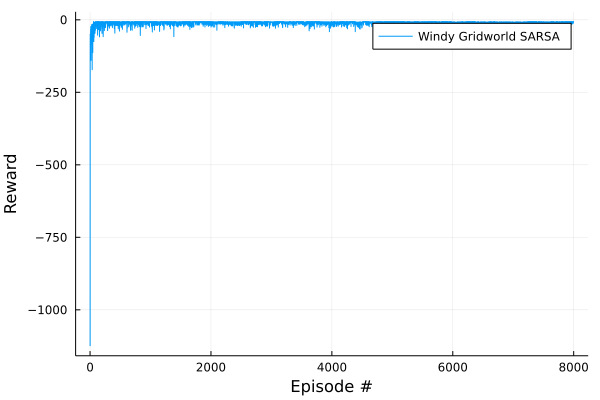

In [133]:
plot(gs, label="Windy Gridworld SARSA", ylabel="Reward", xlabel="Episode #")

In [153]:
arrow = Dict(
    (-1, -1) => "↖️",
    (-1, 0) => "⬆️",
    (-1, 1) => "↗️",
    (0, -1) => "⬅️",
    (0, 1) => "➡️",
    (1, -1) => "↙️",
    (1, 0) => "⬇️",
    (1, 1) => "↘️"
)

M = vcat([ arrow[π_star((i, j))] for i in 1:7, j in 1:10 ], (x->"$(x)").(wind'))
M[4, 8] = "⛳️"
for i in 1:8
    println(join(M[i,:]))
end

➡️⬆️⬅️➡️↘️➡️↘️↗️↗️↘️
⬇️↙️⬇️↗️➡️↘️➡️⬇️↘️↙️
⬇️↘️↘️↘️➡️➡️➡️↘️↘️↙️
↘️↘️↙️↙️↗️↘️↘️⛳️↙️⬅️
➡️↘️⬇️↙️↘️↘️↘️⬇️⬅️⬅️
↗️⬅️↘️➡️↘️↘️➡️⬇️↖️↗️
➡️➡️➡️↘️↘️↘️↗️⬆️↙️↖️
0001112210


In [154]:
S = (4, 1)
τ = []
while S != nothing
    push!(τ, S)
    S = p_windy(S, π_star(S))[2]
end
τ

7-element Vector{Any}:
 (4, 1)
 (5, 2)
 (6, 3)
 (7, 4)
 (7, 5)
 (7, 6)
 (7, 7)

In [155]:
for s in τ
    M[s[1], s[2]] = "✅"
end
for i in 1:7
    println(join(M[i,:]))
end

➡️⬆️⬅️➡️↘️➡️↘️↗️↗️↘️
⬇️↙️⬇️↗️➡️↘️➡️⬇️↘️↙️
⬇️↘️↘️↘️➡️➡️➡️↘️↘️↙️
✅↘️↙️↙️↗️↘️↘️⛳️↙️⬅️
➡️✅⬇️↙️↘️↘️↘️⬇️⬅️⬅️
↗️⬅️✅➡️↘️↘️➡️⬇️↖️↗️
➡️➡️➡️✅✅✅✅⬆️↙️↖️


In [177]:
𝓐_cardinal = [ (0, -1), (-1, 0), (1, 0), (0, 1) ]
Q_star, π_star = sarsa(p0_windy, p_windy, 𝓢_windy, 𝓐_cardinal; γ=1, ε=0.01, α=0.01, N=200000)
M = vcat([ arrow[π_star((i, j))] for i in 1:7, j in 1:10 ], (x->"$(x)").(wind'))
M[4, 8] = "⛳️"
for i in 1:7
    println(join(M[i,:]))
end

➡️➡️⬆️➡️➡️➡️➡️➡️➡️⬇️
➡️⬆️➡️➡️➡️➡️➡️➡️➡️⬇️
➡️➡️➡️➡️➡️➡️➡️⬆️➡️⬇️
➡️➡️➡️➡️➡️➡️➡️⛳️➡️⬇️
⬇️➡️➡️➡️➡️⬅️⬅️⬇️⬅️⬅️
➡️⬇️⬇️➡️⬅️⬅️⬅️⬇️⬅️⬅️
➡️➡️➡️➡️⬅️⬅️⬅️⬅️⬇️⬆️


In [178]:
S = (4, 1)
τ = []
while S != nothing
    push!(τ, S)
    S = p_windy(S, π_star(S))[2]
end
τ

15-element Vector{Any}:
 (4, 1)
 (4, 2)
 (4, 3)
 (4, 4)
 (3, 5)
 (2, 6)
 (1, 7)
 (1, 8)
 (1, 9)
 (1, 10)
 (2, 10)
 (3, 10)
 (4, 10)
 (5, 10)
 (5, 9)

In [174]:
Q_star[(4, 1), (0, 1)]

-16.308711223573955

In [175]:
Q_star[(4, 1), (-1, 0)]

-17.083860434496522

In [176]:
for s in τ
    M[s[1], s[2]] = "✅"
end
for i in 1:7
    println(join(M[i,:]))
end

➡️⬅️➡️➡️➡️➡️✅✅✅✅
➡️➡️➡️➡️➡️✅➡️➡️➡️✅
➡️➡️➡️➡️✅➡️➡️➡️➡️✅
✅✅✅✅➡️➡️➡️⛳️➡️✅
➡️➡️➡️➡️➡️➡️⬅️⬇️✅✅
➡️➡️➡️➡️➡️⬅️⬅️⬇️⬅️⬆️
➡️➡️➡️➡️⬅️⬅️⬅️⬅️⬅️⬅️


> _Exercise 6.10: Stochastic Wind (programming)_ Re-solve the windy gridworld task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal.

In [91]:
function p_stochastic(S, A)
    y, x = S
    nS = (S .+ A) .- (wind[x] + rand(-1:1), 0)
    nS = (clamp(nS[1], 1, 7), clamp(nS[2], 1, 10))

    return nS == (4, 8) ? (0, nothing) : (-1, nS)
end

p_stochastic (generic function with 1 method)

In [92]:
rollout(p0_windy, p_stochastic, 𝓢_windy, 𝓐_windy, π_star, (s, a, r, sp, ap) -> println("$(s) $(a) $(r), $(sp) $(a)"))

(4, 1) (1, 1) -1, (4, 2) (1, 1)
(4, 2) (1, -1) -1, (4, 1) (1, -1)
(4, 1) (1, 1) -1, (6, 2) (1, 1)
(6, 2) (1, 1) -1, (7, 3) (1, 1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1,

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, 

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4)

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, 

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1,

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1,

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0

(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1,

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0

(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1,

(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3)

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)


(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (

(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (

(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0

(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 

(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) 

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, 

(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)


(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)


(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1,

(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7

(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (

(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (

(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0

(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0

(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4)

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1,

(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1

(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1,

(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (

(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1,

(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (5, 3) (1, 0)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (6, 3) (1, -1)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (7, 3) (1

Excessive output truncated after 524300 bytes.

(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (6, 3) (1, 0)
(6, 3) (1, 1) -1, (6, 4) (1, 1)
(6, 4) (1, -1) -1, (5, 3) (1, -1)
(5, 3) (1, 0) -1, (7, 3) (1, 0)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6, 4) (1, -1) -1, (7, 3) (1, -1)
(7, 3) (1, 1) -1, (7, 4) (1, 1)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (7, 4) (1, 0)
(7, 4) (1, 0) -1, (6, 4) (1, 0)
(6

LoadError: InterruptException:

In [93]:
Q_star, π_star, gs = sarsa(p0_windy, p_stochastic, 𝓢_windy, 𝓐_windy; γ=1, ε=0.1, α=0.5, N=8000);

Episode 1 completed
Episode 2 completed
Episode 3 completed
Episode 4 completed
Episode 5 completed
Episode 6 completed
Episode 7 completed
Episode 8 completed
Episode 9 completed
Episode 10 completed
Episode 11 completed
Episode 12 completed
Episode 13 completed
Episode 14 completed
Episode 15 completed
Episode 16 completed
Episode 17 completed
Episode 18 completed
Episode 19 completed
Episode 20 completed
Episode 21 completed
Episode 22 completed
Episode 23 completed
Episode 24 completed
Episode 25 completed
Episode 26 completed
Episode 27 completed
Episode 28 completed
Episode 29 completed
Episode 30 completed
Episode 31 completed
Episode 32 completed
Episode 33 completed
Episode 34 completed
Episode 35 completed
Episode 36 completed
Episode 37 completed
Episode 38 completed
Episode 39 completed
Episode 40 completed
Episode 41 completed
Episode 42 completed
Episode 43 completed
Episode 44 completed
Episode 45 completed
Episode 46 completed
Episode 47 completed
Episode 48 completed
E

Episode 472 completed
Episode 473 completed
Episode 474 completed
Episode 475 completed
Episode 476 completed
Episode 477 completed
Episode 478 completed
Episode 479 completed
Episode 480 completed
Episode 481 completed
Episode 482 completed
Episode 483 completed
Episode 484 completed
Episode 485 completed
Episode 486 completed
Episode 487 completed
Episode 488 completed
Episode 489 completed
Episode 490 completed
Episode 491 completed
Episode 492 completed
Episode 493 completed
Episode 494 completed
Episode 495 completed
Episode 496 completed
Episode 497 completed
Episode 498 completed
Episode 499 completed
Episode 500 completed
Episode 501 completed
Episode 502 completed
Episode 503 completed
Episode 504 completed
Episode 505 completed
Episode 506 completed
Episode 507 completed
Episode 508 completed
Episode 509 completed
Episode 510 completed
Episode 511 completed
Episode 512 completed
Episode 513 completed
Episode 514 completed
Episode 515 completed
Episode 516 completed
Episode 51

Episode 938 completed
Episode 939 completed
Episode 940 completed
Episode 941 completed
Episode 942 completed
Episode 943 completed
Episode 944 completed
Episode 945 completed
Episode 946 completed
Episode 947 completed
Episode 948 completed
Episode 949 completed
Episode 950 completed
Episode 951 completed
Episode 952 completed
Episode 953 completed
Episode 954 completed
Episode 955 completed
Episode 956 completed
Episode 957 completed
Episode 958 completed
Episode 959 completed
Episode 960 completed
Episode 961 completed
Episode 962 completed
Episode 963 completed
Episode 964 completed
Episode 965 completed
Episode 966 completed
Episode 967 completed
Episode 968 completed
Episode 969 completed
Episode 970 completed
Episode 971 completed
Episode 972 completed
Episode 973 completed
Episode 974 completed
Episode 975 completed
Episode 976 completed
Episode 977 completed
Episode 978 completed
Episode 979 completed
Episode 980 completed
Episode 981 completed
Episode 982 completed
Episode 98

Episode 1386 completed
Episode 1387 completed
Episode 1388 completed
Episode 1389 completed
Episode 1390 completed
Episode 1391 completed
Episode 1392 completed
Episode 1393 completed
Episode 1394 completed
Episode 1395 completed
Episode 1396 completed
Episode 1397 completed
Episode 1398 completed
Episode 1399 completed
Episode 1400 completed
Episode 1401 completed
Episode 1402 completed
Episode 1403 completed
Episode 1404 completed
Episode 1405 completed
Episode 1406 completed
Episode 1407 completed
Episode 1408 completed
Episode 1409 completed
Episode 1410 completed
Episode 1411 completed
Episode 1412 completed
Episode 1413 completed
Episode 1414 completed
Episode 1415 completed
Episode 1416 completed
Episode 1417 completed
Episode 1418 completed
Episode 1419 completed
Episode 1420 completed
Episode 1421 completed
Episode 1422 completed
Episode 1423 completed
Episode 1424 completed
Episode 1425 completed
Episode 1426 completed
Episode 1427 completed
Episode 1428 completed
Episode 142

Episode 1832 completed
Episode 1833 completed
Episode 1834 completed
Episode 1835 completed
Episode 1836 completed
Episode 1837 completed
Episode 1838 completed
Episode 1839 completed
Episode 1840 completed
Episode 1841 completed
Episode 1842 completed
Episode 1843 completed
Episode 1844 completed
Episode 1845 completed
Episode 1846 completed
Episode 1847 completed
Episode 1848 completed
Episode 1849 completed
Episode 1850 completed
Episode 1851 completed
Episode 1852 completed
Episode 1853 completed
Episode 1854 completed
Episode 1855 completed
Episode 1856 completed
Episode 1857 completed
Episode 1858 completed
Episode 1859 completed
Episode 1860 completed
Episode 1861 completed
Episode 1862 completed
Episode 1863 completed
Episode 1864 completed
Episode 1865 completed
Episode 1866 completed
Episode 1867 completed
Episode 1868 completed
Episode 1869 completed
Episode 1870 completed
Episode 1871 completed
Episode 1872 completed
Episode 1873 completed
Episode 1874 completed
Episode 187

Episode 2278 completed
Episode 2279 completed
Episode 2280 completed
Episode 2281 completed
Episode 2282 completed
Episode 2283 completed
Episode 2284 completed
Episode 2285 completed
Episode 2286 completed
Episode 2287 completed
Episode 2288 completed
Episode 2289 completed
Episode 2290 completed
Episode 2291 completed
Episode 2292 completed
Episode 2293 completed
Episode 2294 completed
Episode 2295 completed
Episode 2296 completed
Episode 2297 completed
Episode 2298 completed
Episode 2299 completed
Episode 2300 completed
Episode 2301 completed
Episode 2302 completed
Episode 2303 completed
Episode 2304 completed
Episode 2305 completed
Episode 2306 completed
Episode 2307 completed
Episode 2308 completed
Episode 2309 completed
Episode 2310 completed
Episode 2311 completed
Episode 2312 completed
Episode 2313 completed
Episode 2314 completed
Episode 2315 completed
Episode 2316 completed
Episode 2317 completed
Episode 2318 completed
Episode 2319 completed
Episode 2320 completed
Episode 232

Episode 2724 completed
Episode 2725 completed
Episode 2726 completed
Episode 2727 completed
Episode 2728 completed
Episode 2729 completed
Episode 2730 completed
Episode 2731 completed
Episode 2732 completed
Episode 2733 completed
Episode 2734 completed
Episode 2735 completed
Episode 2736 completed
Episode 2737 completed
Episode 2738 completed
Episode 2739 completed
Episode 2740 completed
Episode 2741 completed
Episode 2742 completed
Episode 2743 completed
Episode 2744 completed
Episode 2745 completed
Episode 2746 completed
Episode 2747 completed
Episode 2748 completed
Episode 2749 completed
Episode 2750 completed
Episode 2751 completed
Episode 2752 completed
Episode 2753 completed
Episode 2754 completed
Episode 2755 completed
Episode 2756 completed
Episode 2757 completed
Episode 2758 completed
Episode 2759 completed
Episode 2760 completed
Episode 2761 completed
Episode 2762 completed
Episode 2763 completed
Episode 2764 completed
Episode 2765 completed
Episode 2766 completed
Episode 276

Episode 3170 completed
Episode 3171 completed
Episode 3172 completed
Episode 3173 completed
Episode 3174 completed
Episode 3175 completed
Episode 3176 completed
Episode 3177 completed
Episode 3178 completed
Episode 3179 completed
Episode 3180 completed
Episode 3181 completed
Episode 3182 completed
Episode 3183 completed
Episode 3184 completed
Episode 3185 completed
Episode 3186 completed
Episode 3187 completed
Episode 3188 completed
Episode 3189 completed
Episode 3190 completed
Episode 3191 completed
Episode 3192 completed
Episode 3193 completed
Episode 3194 completed
Episode 3195 completed
Episode 3196 completed
Episode 3197 completed
Episode 3198 completed
Episode 3199 completed
Episode 3200 completed
Episode 3201 completed
Episode 3202 completed
Episode 3203 completed
Episode 3204 completed
Episode 3205 completed
Episode 3206 completed
Episode 3207 completed
Episode 3208 completed
Episode 3209 completed
Episode 3210 completed
Episode 3211 completed
Episode 3212 completed
Episode 321

Episode 3616 completed
Episode 3617 completed
Episode 3618 completed
Episode 3619 completed
Episode 3620 completed
Episode 3621 completed
Episode 3622 completed
Episode 3623 completed
Episode 3624 completed
Episode 3625 completed
Episode 3626 completed
Episode 3627 completed
Episode 3628 completed
Episode 3629 completed
Episode 3630 completed
Episode 3631 completed
Episode 3632 completed
Episode 3633 completed
Episode 3634 completed
Episode 3635 completed
Episode 3636 completed
Episode 3637 completed
Episode 3638 completed
Episode 3639 completed
Episode 3640 completed
Episode 3641 completed
Episode 3642 completed
Episode 3643 completed
Episode 3644 completed
Episode 3645 completed
Episode 3646 completed
Episode 3647 completed
Episode 3648 completed
Episode 3649 completed
Episode 3650 completed
Episode 3651 completed
Episode 3652 completed
Episode 3653 completed
Episode 3654 completed
Episode 3655 completed
Episode 3656 completed
Episode 3657 completed
Episode 3658 completed
Episode 365

Episode 4062 completed
Episode 4063 completed
Episode 4064 completed
Episode 4065 completed
Episode 4066 completed
Episode 4067 completed
Episode 4068 completed
Episode 4069 completed
Episode 4070 completed
Episode 4071 completed
Episode 4072 completed
Episode 4073 completed
Episode 4074 completed
Episode 4075 completed
Episode 4076 completed
Episode 4077 completed
Episode 4078 completed
Episode 4079 completed
Episode 4080 completed
Episode 4081 completed
Episode 4082 completed
Episode 4083 completed
Episode 4084 completed
Episode 4085 completed
Episode 4086 completed
Episode 4087 completed
Episode 4088 completed
Episode 4089 completed
Episode 4090 completed
Episode 4091 completed
Episode 4092 completed
Episode 4093 completed
Episode 4094 completed
Episode 4095 completed
Episode 4096 completed
Episode 4097 completed
Episode 4098 completed
Episode 4099 completed
Episode 4100 completed
Episode 4101 completed
Episode 4102 completed
Episode 4103 completed
Episode 4104 completed
Episode 410

Episode 4508 completed
Episode 4509 completed
Episode 4510 completed
Episode 4511 completed
Episode 4512 completed
Episode 4513 completed
Episode 4514 completed
Episode 4515 completed
Episode 4516 completed
Episode 4517 completed
Episode 4518 completed
Episode 4519 completed
Episode 4520 completed
Episode 4521 completed
Episode 4522 completed
Episode 4523 completed
Episode 4524 completed
Episode 4525 completed
Episode 4526 completed
Episode 4527 completed
Episode 4528 completed
Episode 4529 completed
Episode 4530 completed
Episode 4531 completed
Episode 4532 completed
Episode 4533 completed
Episode 4534 completed
Episode 4535 completed
Episode 4536 completed
Episode 4537 completed
Episode 4538 completed
Episode 4539 completed
Episode 4540 completed
Episode 4541 completed
Episode 4542 completed
Episode 4543 completed
Episode 4544 completed
Episode 4545 completed
Episode 4546 completed
Episode 4547 completed
Episode 4548 completed
Episode 4549 completed
Episode 4550 completed
Episode 455

Episode 4954 completed
Episode 4955 completed
Episode 4956 completed
Episode 4957 completed
Episode 4958 completed
Episode 4959 completed
Episode 4960 completed
Episode 4961 completed
Episode 4962 completed
Episode 4963 completed
Episode 4964 completed
Episode 4965 completed
Episode 4966 completed
Episode 4967 completed
Episode 4968 completed
Episode 4969 completed
Episode 4970 completed
Episode 4971 completed
Episode 4972 completed
Episode 4973 completed
Episode 4974 completed
Episode 4975 completed
Episode 4976 completed
Episode 4977 completed
Episode 4978 completed
Episode 4979 completed
Episode 4980 completed
Episode 4981 completed
Episode 4982 completed
Episode 4983 completed
Episode 4984 completed
Episode 4985 completed
Episode 4986 completed
Episode 4987 completed
Episode 4988 completed
Episode 4989 completed
Episode 4990 completed
Episode 4991 completed
Episode 4992 completed
Episode 4993 completed
Episode 4994 completed
Episode 4995 completed
Episode 4996 completed
Episode 499

Episode 5400 completed
Episode 5401 completed
Episode 5402 completed
Episode 5403 completed
Episode 5404 completed
Episode 5405 completed
Episode 5406 completed
Episode 5407 completed
Episode 5408 completed
Episode 5409 completed
Episode 5410 completed
Episode 5411 completed
Episode 5412 completed
Episode 5413 completed
Episode 5414 completed
Episode 5415 completed
Episode 5416 completed
Episode 5417 completed
Episode 5418 completed
Episode 5419 completed
Episode 5420 completed
Episode 5421 completed
Episode 5422 completed
Episode 5423 completed
Episode 5424 completed
Episode 5425 completed
Episode 5426 completed
Episode 5427 completed
Episode 5428 completed
Episode 5429 completed
Episode 5430 completed
Episode 5431 completed
Episode 5432 completed
Episode 5433 completed
Episode 5434 completed
Episode 5435 completed
Episode 5436 completed
Episode 5437 completed
Episode 5438 completed
Episode 5439 completed
Episode 5440 completed
Episode 5441 completed
Episode 5442 completed
Episode 544

Episode 5846 completed
Episode 5847 completed
Episode 5848 completed
Episode 5849 completed
Episode 5850 completed
Episode 5851 completed
Episode 5852 completed
Episode 5853 completed
Episode 5854 completed
Episode 5855 completed
Episode 5856 completed
Episode 5857 completed
Episode 5858 completed
Episode 5859 completed
Episode 5860 completed
Episode 5861 completed
Episode 5862 completed
Episode 5863 completed
Episode 5864 completed
Episode 5865 completed
Episode 5866 completed
Episode 5867 completed
Episode 5868 completed
Episode 5869 completed
Episode 5870 completed
Episode 5871 completed
Episode 5872 completed
Episode 5873 completed
Episode 5874 completed
Episode 5875 completed
Episode 5876 completed
Episode 5877 completed
Episode 5878 completed
Episode 5879 completed
Episode 5880 completed
Episode 5881 completed
Episode 5882 completed
Episode 5883 completed
Episode 5884 completed
Episode 5885 completed
Episode 5886 completed
Episode 5887 completed
Episode 5888 completed
Episode 588

Episode 6292 completed
Episode 6293 completed
Episode 6294 completed
Episode 6295 completed
Episode 6296 completed
Episode 6297 completed
Episode 6298 completed
Episode 6299 completed
Episode 6300 completed
Episode 6301 completed
Episode 6302 completed
Episode 6303 completed
Episode 6304 completed
Episode 6305 completed
Episode 6306 completed
Episode 6307 completed
Episode 6308 completed
Episode 6309 completed
Episode 6310 completed
Episode 6311 completed
Episode 6312 completed
Episode 6313 completed
Episode 6314 completed
Episode 6315 completed
Episode 6316 completed
Episode 6317 completed
Episode 6318 completed
Episode 6319 completed
Episode 6320 completed
Episode 6321 completed
Episode 6322 completed
Episode 6323 completed
Episode 6324 completed
Episode 6325 completed
Episode 6326 completed
Episode 6327 completed
Episode 6328 completed
Episode 6329 completed
Episode 6330 completed
Episode 6331 completed
Episode 6332 completed
Episode 6333 completed
Episode 6334 completed
Episode 633

Episode 6738 completed
Episode 6739 completed
Episode 6740 completed
Episode 6741 completed
Episode 6742 completed
Episode 6743 completed
Episode 6744 completed
Episode 6745 completed
Episode 6746 completed
Episode 6747 completed
Episode 6748 completed
Episode 6749 completed
Episode 6750 completed
Episode 6751 completed
Episode 6752 completed
Episode 6753 completed
Episode 6754 completed
Episode 6755 completed
Episode 6756 completed
Episode 6757 completed
Episode 6758 completed
Episode 6759 completed
Episode 6760 completed
Episode 6761 completed
Episode 6762 completed
Episode 6763 completed
Episode 6764 completed
Episode 6765 completed
Episode 6766 completed
Episode 6767 completed
Episode 6768 completed
Episode 6769 completed
Episode 6770 completed
Episode 6771 completed
Episode 6772 completed
Episode 6773 completed
Episode 6774 completed
Episode 6775 completed
Episode 6776 completed
Episode 6777 completed
Episode 6778 completed
Episode 6779 completed
Episode 6780 completed
Episode 678

Episode 7184 completed
Episode 7185 completed
Episode 7186 completed
Episode 7187 completed
Episode 7188 completed
Episode 7189 completed
Episode 7190 completed
Episode 7191 completed
Episode 7192 completed
Episode 7193 completed
Episode 7194 completed
Episode 7195 completed
Episode 7196 completed
Episode 7197 completed
Episode 7198 completed
Episode 7199 completed
Episode 7200 completed
Episode 7201 completed
Episode 7202 completed
Episode 7203 completed
Episode 7204 completed
Episode 7205 completed
Episode 7206 completed
Episode 7207 completed
Episode 7208 completed
Episode 7209 completed
Episode 7210 completed
Episode 7211 completed
Episode 7212 completed
Episode 7213 completed
Episode 7214 completed
Episode 7215 completed
Episode 7216 completed
Episode 7217 completed
Episode 7218 completed
Episode 7219 completed
Episode 7220 completed
Episode 7221 completed
Episode 7222 completed
Episode 7223 completed
Episode 7224 completed
Episode 7225 completed
Episode 7226 completed
Episode 722

Episode 7630 completed
Episode 7631 completed
Episode 7632 completed
Episode 7633 completed
Episode 7634 completed
Episode 7635 completed
Episode 7636 completed
Episode 7637 completed
Episode 7638 completed
Episode 7639 completed
Episode 7640 completed
Episode 7641 completed
Episode 7642 completed
Episode 7643 completed
Episode 7644 completed
Episode 7645 completed
Episode 7646 completed
Episode 7647 completed
Episode 7648 completed
Episode 7649 completed
Episode 7650 completed
Episode 7651 completed
Episode 7652 completed
Episode 7653 completed
Episode 7654 completed
Episode 7655 completed
Episode 7656 completed
Episode 7657 completed
Episode 7658 completed
Episode 7659 completed
Episode 7660 completed
Episode 7661 completed
Episode 7662 completed
Episode 7663 completed
Episode 7664 completed
Episode 7665 completed
Episode 7666 completed
Episode 7667 completed
Episode 7668 completed
Episode 7669 completed
Episode 7670 completed
Episode 7671 completed
Episode 7672 completed
Episode 767

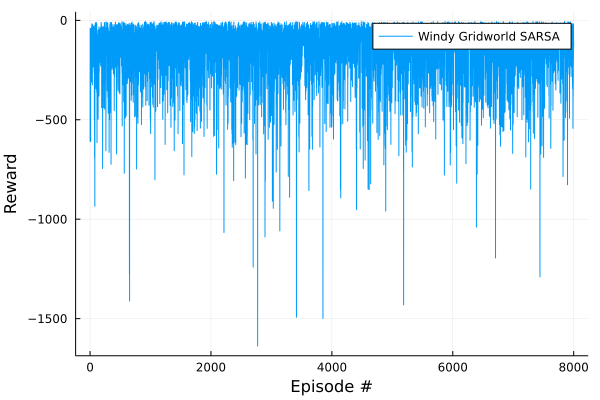

In [94]:
plot(gs, label="Windy Gridworld SARSA", ylabel="Reward", xlabel="Episode #")

In [95]:
M = vcat([ arrow[π_star((i, j))] for i in 1:7, j in 1:10 ], (x->"$(x)").(wind'))
M[4, 8] = "⛳️"
for i in 1:7
    println(join(M[i,:]))
end

➡️↙️↙️↙️➡️⬇️⬆️↗️↗️⬇️
⬅️↖️↙️⬅️⬇️↙️➡️↙️↙️↘️
⬆️↘️↙️⬇️↙️⬆️⬆️⬆️➡️↘️
➡️➡️↖️⬇️↖️↘️↙️⛳️➡️➡️
↖️↘️⬇️↘️↘️↙️⬅️↙️➡️↘️
➡️↗️➡️⬇️↘️⬇️➡️➡️⬅️⬆️
↙️➡️↘️➡️↘️↘️⬇️⬇️↙️⬆️


In [96]:
S = (4, 1)
τ = []
while S != nothing
    push!(τ, S)
    S = p_stochastic(S, π_star(S))[2]
end
τ

LoadError: InterruptException:

In [66]:
for s in τ
    M[s[1], s[2]] = "✅"
end
for i in 1:7
    println(join(M[i,:]))
end

LoadError: InterruptException:

## Q-Learning: Off-policy TD Control

> What is the backup diagram for Q-learning?


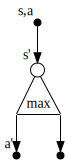

In [100]:
using GraphViz

dot"""
digraph name {
    layout = dot
    splines = true
    node [ shape=circle label=""]
    sa [ style=filled, label="", fillcolor=black shape=circle fixedsize=shape width=0.1 height=0.1 xlabel="s,a"];
    sp [ label="" shape=circle fixedsize=shape width=0.2 height=0.2 xlabel="s'"]
    ap1 [ style=filled fillcolor=black fixedsize=shape width=0.1 height=0.1 xlabel="a'"];
    ap2 [ style=filled fillcolor=black fixedsize=shape width=0.1 height=0.1 ];
    mid1 [ style=invis width=0.0 height=0.0];
    mid2 [ style=invis width=0.0 height=0.0];
    sa -> sp;
    sp -> mid1 [arrowhead=none];
    mid1 -> ap1;
    sp -> mid2 [arrowhead=none];
    mid2 -> ap2;
    mid1 -> mid2 [arrowhead=none, label="max"];

    {rank = same; mid1; mid2}
}
"""

In [122]:
function q_learning(p0, p, 𝓢, 𝓐; γ=0.99, N=1000, α=0.1, ε=0.05)
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    ε_greedy(s) = rand() < ε ? rand(𝓐) : argmax(a -> Q[(s, a)], 𝓐)
    update!(s, a, r, sp, ap) = Q[(s, a)] += α * (r + γ*maximum([Q[(s, a)] for a in 𝓐]) - Q[(s, a)])
    gs = Float64[]
    for i in 1:N
        push!(gs, rollout(p0, p, 𝓢, 𝓐, ε_greedy, update!; γ=γ))
    end

    return Q, s -> argmax(a -> Q[(s, a)], 𝓐), gs
end

q_learning (generic function with 1 method)

In [123]:
width = 12
height = 4

𝓢_cliff = [ [ (4, 1) ] ; vec([ (i, j) for i in 1:(height-1), j in 1:width]) ]

𝓐_cliff = [ :left, :up, :right, :down ]

function p_cliff_walking(S, A)
    i, j = S
    
    if A == :left
        j = max(j - 1, 1)
    elseif A == :up
        i = max(i - 1, 1)
    elseif A == :right
        j = min(j + 1, 12)
    elseif A == :down
        i = min(i + 1, 4)
    end
    
    if (i, j) == (height, width)
        return -1, nothing
    end
    
    if i == height && j in 2:(width - 1)
        return -100, (4, 1)
    end
    
    return -1, (i, j)
end

p0_cliff() = (4, 1)

p0_cliff (generic function with 1 method)

In [124]:
Q_star_sarsa, π_star_sarsa, gs_sarsa = sarsa(p0_cliff, p_cliff_walking, 𝓢_cliff, 𝓐_cliff; γ=1, ε=0.1, α=0.5, N=8000);

In [125]:
Q_star_q, π_star_q, gs_q = q_learning(p0_cliff, p_cliff_walking, 𝓢_cliff, 𝓐_cliff; γ=1, ε=0.1, α=0.5, N=8000);

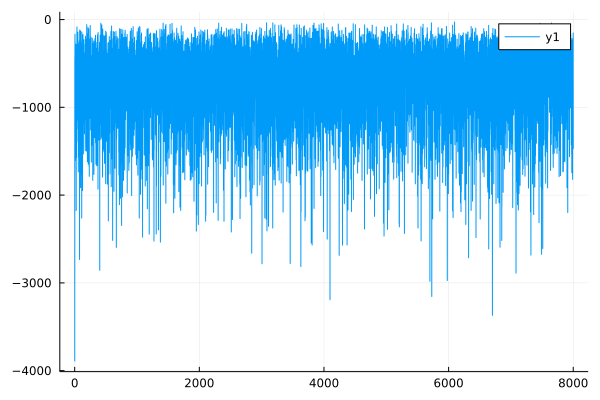

In [126]:
plot(gs_q)

In [129]:
V = vcat(
    [Q_star[((i, j), π_star((i, j)))] for i in 1:3, j in 1:12 ],
    hcat(Q_star[((4, 1), π_star((4, 1)))], -30*ones(11)')
)

4×12 Matrix{Float64}:
 -22.3357  -20.4862  -18.0188  -15.662   …   -7.5223   -7.58312   -2.00115
 -23.8754  -23.1348  -22.5968  -21.9409     -11.0153   -9.02181   -1.00001
 -25.3652  -23.1897  -23.282   -27.2774     -14.7231   -1.01649    0.0
 -26.4594  -30.0     -30.0     -30.0        -30.0     -30.0      -30.0

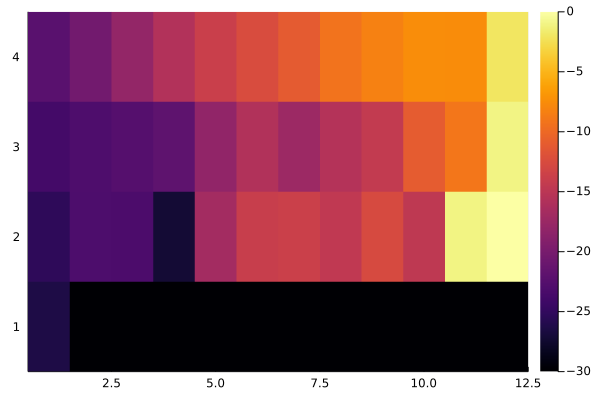

In [130]:
heatmap(V[end:-1:1, :])

In [ ]:
policy = vcat(
    [π_star[(i, j))] for i in 1:3, j in 1:12 ],
    hcat(Q_star[((4, 1), π_star((4, 1)))], -30*ones(11)')
)

> _Exercise 6.11:_ Why is Q-learning considered an _off-policy_ control method?

Q-learning is considered off-policy because the behavior policy (which is typically an $\varepsilon$-greedy policy with respect to $Q$, but not always) is distinct from the target policy, which is greedy (not $\varepsilon$-greedy) with respect to the learned $Q$ function.

> _Exercise 6.12:_ Suppose action selection is greedy. Is Q-learning then exactly the same algorithm as Sarsa? Will they make exactly the same action selections and weight updates?

In this case, Q-learning and SARSA would be identical in terms of action selections and weight updates. However, this amounts to having a non-covering behavior policy, which means that not every state-action pair will continue to be visited infinitely. Therefore, we would expect the algorithm modified in this way to be totally unable to converge.

> _Exercise 6.13:_ s